# Super Resolution and EDSR

##### This task intends to implement super-resolution operations on a single image in order to achieve the final effect of enlarging the image by a factor of two.
These operations will be divided into the following parts.
1. Set the format threshold and load the dataset DIV2K dataset.
2. Set up an EDSR, set up the input channels and output channels.
3. Set up the training loop
4. Input the training set into the model and store the weights.
5. Perform super-resolution using images from outside the training set and observe the results, adjusting the parameters to obtain the best solution given the available hardware.

In [1]:
import os
import glob
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from tqdm import tqdm
import os
from os.path import join
import matplotlib.pyplot as plt
import torch.nn as nn

##### Download and unzip the dataset. This dataset is a DIV2K. In this task, it needs to be downloaded and decompressed to the appropriate location location first. Also delete the redundant zip package.

In [2]:
import requests
import zipfile
import os
from tqdm import tqdm
train_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip'
valid_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip'
train_save_path = './DIV2K_train_LR_bicubic_X2.zip'
valid_save_path = './DIV2K_valid_LR_bicubic_X2.zip'

print("Downloading training dataset...")
response = requests.get(train_url, stream=True)

total_size = int(response.headers.get('content-length', 0))
block_size = 1024  
progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

with open(train_save_path, 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)

progress_bar.close()
print("Downloading validation dataset...")
response = requests.get(valid_url, stream=True)

total_size = int(response.headers.get('content-length', 0))
progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

with open(valid_save_path, 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)

progress_bar.close()
print("Extracting training dataset...")
with zipfile.ZipFile(train_save_path, 'r') as zip_ref:
    zip_ref.extractall('./')
print("Extracting validation dataset...")
with zipfile.ZipFile(valid_save_path, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(train_save_path)
os.remove(valid_save_path)

print("Dataset downloaded and extracted successfully.")


100%|███████████████████████████████████████████████████████████████████████████████| 925M/925M [04:17<00:00, 3.59MB/s]


100%|███████████████████████████████████████████████████████████████████████████████| 118M/118M [00:36<00:00, 3.21MB/s]


Extracting training dataset...
Extracting validation dataset...
Dataset downloaded and extracted successfully.


#### First, guidance on a file format. This is used to determine if the file meets the input criteria. This file accepts one of the .png, .jpg, .jpeg or .bmp extension endings.

In [3]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.bmp'])

##### Next, a function is set for cropping the size. He accepts the crop size and zooms in. in order to get the closest size that can be divided by the enlargement factor.

In [4]:
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

##### Now I want to customise the dataset class. This construct will support four parameters: input directory crop size magnification factor and training state.In addition to this it also defines the way in which the data can be prepared by opening the image file, resizing it and converting it to a tensor. Both the low resolution image and the high resolution tensor will be returned.Finally the number of images in the dataset is returned.

In [5]:
class DIV2KDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, crop_size, upscale_factor, training):
        self.image_files = [join(root_dir, x) for x in os.listdir(root_dir) if is_image_file(x)]
        self.crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.upscale_factor = upscale_factor
        self.training = training

    def __getitem__(self, index):
        hr_image = Image.open(self.image_files[index]).convert('RGB')
        lr_image = hr_image.resize((self.crop_size, self.crop_size), Image.BICUBIC)
        hr_image = lr_image.resize((self.crop_size * self.upscale_factor, self.crop_size * self.upscale_factor), Image.BICUBIC)
        hr_image = transforms.ToTensor()(hr_image)
        lr_image = transforms.ToTensor()(lr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_files)

##### Here, I set two parameters for image processing and super-resolution. One of them is crop_size, which divides the input layer into smaller image blocks for processing. upscale_factor is the magnification factor, which determines the magnification of the low-resolution image into a high-resolution image.

In [6]:
crop_size = 64
upscale_factor = 2

##### Enter the train file as training and set val to the test set. At this point, the 64 inputs are set as a batch, and the data is broken up to encourage the model to learn the features better.

In [7]:
train_set = DIV2KDataset('./DIV2K_train_LR_bicubic/X2', crop_size, upscale_factor, training=True)
valid_set = DIV2KDataset('./DIV2K_valid_LR_bicubic/X2', crop_size, upscale_factor, training=False)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=32, shuffle=False)

##### In this experiment we used the DIV2K training set, a treasure trove of 800 training sets and 100 test sets. The images are reduced by one half and the model extracts the details from the reduced images. The final weights are output.

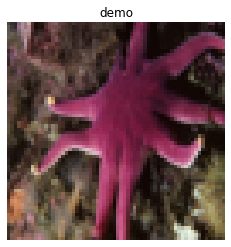

number: 800


In [8]:
import matplotlib.pyplot as plt
import numpy as np
index = 0
image, _ = train_set[index]  
image = np.transpose(image, (1, 2, 0))  
plt.imshow(image)
plt.axis('off')
plt.title('demo')
plt.show()
num_train_files = len(train_set)
print("number:", num_train_files)

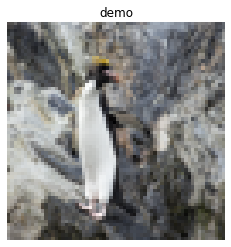

nember: 100


In [9]:
import matplotlib.pyplot as plt
import numpy as np
index = 0
image, _ = valid_set[index]  
image = np.transpose(image, (1, 2, 0))  
plt.imshow(image)
plt.axis('off')
plt.title('demo')
plt.show()
num_valid_files = len(valid_set)
print("nember:", num_valid_files)

##### Creates a residual block that accepts input and produces the same number of channels of output. It is used to facilitate the flow of information and to suppress the disappearance of gradients.

In [10]:
def make_residual_block(in_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
    )

##### Finally, define a model for EDSR. I have made these definitions:
self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=9, padding=4): this is the first convolution layer of the model, which takes the input image and performs a convolution operation to generate a 64-channel feature map.

self.residual_blocks = nn.Sequential(*[make_residual_block(64) for _ in range(num_residual_blocks)]): this is a series of stacks of residual blocks, using the make_residual_block function num_residual_blocks are created.

self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1): this is the second convolution layer of the model, which convolves the output of the residual blocks to produce a 64-channel feature map.

self.upscale = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=upscale_factor, padding=1, output_padding=1): this is the upscale layer, which uses a transpose convolution operation to scale up the size of the feature map, where upscale_factor specifies the magnification factor.

self.conv3 = nn.Conv2d(64, out_channels, kernel_size=9, padding=4): this is the final convolution layer of the model, which maps the upsampled feature map to the final output image. out_channels specifies the number of channels in the output image.

In [11]:
class EDSR(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks, upscale_factor=2):
        super(EDSR, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.residual_blocks = nn.Sequential(
            *[make_residual_block(64) for _ in range(num_residual_blocks)]
        )
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upscale = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=upscale_factor, padding=1, output_padding=upscale_factor-1)
        self.conv3 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        conv1_out = self.conv1(x)
        res_out = self.residual_blocks(conv1_out)
        conv2_out = self.conv2(res_out)
        up_out = self.upscale(conv1_out + conv2_out)  # Upscale
        conv3_out = self.conv3(up_out)  # skip connection
        return conv3_out


##### Finally, prepare a training loop and add the required parameters. For example, the cuda training model, the loss function and optimizer, and the number of iterations.In the training loop, I add a tqdm to record the progress of the training and to store the final weights.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EDSR(3, 3, 16, upscale_factor).to(device)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20  
save_path = './edsr_weights.pth'

Epoch [20/20]: 100%|█████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.41it/s, loss=0.00183]

Finished Training


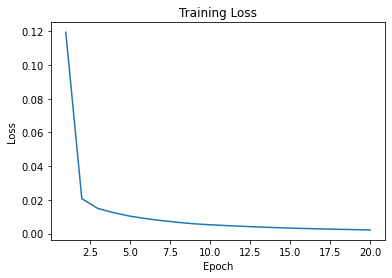

In [13]:
import matplotlib.pyplot as plt

train_losses = []  

for epoch in range(num_epochs):
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    epoch_loss = 0.0  
    for i, (inputs, labels) in enumerate(loop):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)  

    torch.save(model.state_dict(), save_path)

print('Finished Training')

plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


##### Now, I need to validate the model. Add the training saved weights to the program. Assign a dedicated test graph to assist in the testing. And open the image file using the 'Image.open' function.

In [14]:
in_channels = 3
out_channels = 3
num_residual_blocks = 16
upscale_factor = 3
model_path = './edsr_weights.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EDSR(in_channels, out_channels, num_residual_blocks, upscale_factor).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()


image_path = './test.jpg'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output_tensor = model(image_tensor)


output_image = output_tensor.squeeze().cpu().detach().clamp(0, 1).numpy().transpose(1, 2, 0)
output_image = (output_image * 255).astype('uint8')

output_image = Image.fromarray(output_image)
output_image.save('./super_res_image.jpg')

##### Load the weights for BERT and set the model to evaluation mode. I open an image. This model constructs a function that accepts three parameters: the number of channels the number of output channels and the number of residual blocks.

In [15]:
model = EDSR(3, 3, 16)
model.load_state_dict(torch.load('./edsr_weights.pth'))
model = model.to(device)
model.eval()  
image_path = './test.jpg'  
image = Image.open(image_path)

##### Next define the pre-processing of the image. I need to convert the image to a tensor and normalise it.


In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(image).unsqueeze(0).to(device)

##### Finally, the processed model is post-processed and the final image is output. I have put together the original image and the final image as a comparison. The image still retains most of its detail when zoomed in twice as much.

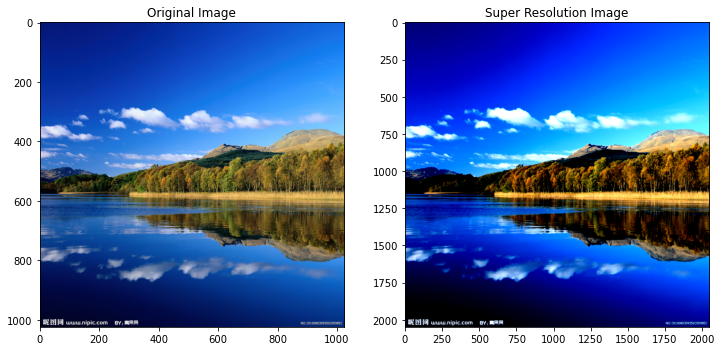

In [17]:
import numpy as np

with torch.no_grad():
    output = model(image_tensor)

output_image = output.squeeze().cpu().detach()
output_image = output_image[:3, :, :]  

output_image = output_image / 2 + 0.5

scaling_factor = 0.8
output_image = output_image * scaling_factor


output_image = output_image.clamp(0, 1)

output_image = output_image.permute(1, 2, 0).numpy()

output_image = (output_image * 255).astype(np.uint8)

output_image = Image.fromarray(output_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].title.set_text('Original Image')    
ax[1].imshow(output_image)
ax[1].title.set_text('Super Resolution Image')
output_image.save('./super_res_image.jpg')

plt.show()